<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a><div align="center">This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.</div>

# Data Analysis with Pandas

[Pandas](https://pandas.pydata.org/) is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

We are going to use data produced by TissueMAPS.  If you have not yet done it, please download the feature values from TissueMAPS into a file in the current directory by running the following command in a terminal (substitute `172.23.X.Y` with the actual server IP address):

```
tm_client --host 172.23.X.Y --port 1000 --user tissuemaps --password bio325uzh \
  experiment -e BIO325_CRISPR_Yap feauture-values download Cells $PWD
```

**Note:** the above command has to be on *one single* terminal command-line.

The `tm_client` invocation should produce two sets of 4 `.csv` files each:
```
BIO325_CRISPR_Yap_p1_D07_Cells_metadata.csv
BIO325_CRISPR_Yap_p1_D08_Cells_metadata.csv
BIO325_CRISPR_Yap_p1_D09_Cells_metadata.csv
BIO325_CRISPR_Yap_p1_D10_Cells_metadata.csv
BIO325_CRISPR_Yap_p1_D07_Cells_feature-values.csv
BIO325_CRISPR_Yap_p1_D08_Cells_feature-values.csv
BIO325_CRISPR_Yap_p1_D09_Cells_feature-values.csv
BIO325_CRISPR_Yap_p1_D20_Cells_feature-values.csv
```

Each *metadata* CSV file contains basic data about every cell that TissueMAPS was able to detect in a given plate well ("D07", "D08", "D09", "D10").

Each *feature-values* CSV file contains additional measurements about the same cells performed by TissueMAPS in the "Jterator" pipeline; *feature-values* files are also divided per well.

We can use PanDas to inspect the contents of these files and perform some statistics and plotting.

## Preamble

Before using PanDas, we must import it.  PanDas depends on NumPy and can interchange data with it, so let's import both of them using abbreviated names.

In [1]:
import numpy as np
import pandas as pd

Evaluating the following cell allows us to display plots *in* the Python notebook:

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# make large figures so we can appreciate details
plt.rc('figure', figsize=(20.0, 15.0))

## Load data

We can use Panda's `read_csv()` function to read a CSV file into a Python data structure: 

In [3]:
# "metadata" file for well D10
md10 = pd.read_csv("BIO325_CRISPR_Yap_p1_D10_Cells_metadata.csv")

In [4]:
# "feature values" for well D10
fv10 = pd.read_csv('BIO325_CRISPR_Yap_p1_D10_Cells_feature-values.csv')

The return object from `read_csv()` is a `DataFrame` object, which displays nicely in the notebook as tabular data:

In [5]:
md10[:5]  # display the first 5 rows

,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,Classification-5,TPlus
0,491297,p1,D10,0,0,0,0,1,1,0.0,0.0
1,491298,p1,D10,0,0,0,0,2,1,0.0,0.0
2,491299,p1,D10,0,0,0,0,3,1,0.0,0.0
3,491300,p1,D10,0,0,0,0,4,1,0.0,0.0
4,491301,p1,D10,0,0,0,0,5,1,0.0,0.0


Note that the first row of the CSV file was used to name the column, not to provide actual data.

## Access table data

A `DataFrame` object as a `.shape` attribute like any 2D NumPy array:

In [6]:
md10.shape

(30764, 11)

The above shows that our table has 30764 rows across 11 columns.  

**Note: *row index comes first!*** (This will be important when accessing data with numerical indices below.)

### Read entire columns

You can get an *entire column* out of the table, by using Python's `[]` notation with the column name:

In [7]:
labels = md10['label']

In [8]:
labels[:5] # print first 5 label values

0    1
1    2
2    3
3    4
4    5
Name: label, dtype: int64

A column of a PanDas `DataFrame` is a `pandas.Series` object, which closely resembles a NumPy array.

You can use all normal Python and NumPy array methods on it.

In [9]:
len(labels)

30764

In [10]:
sum(labels)

19209762

In [11]:
unique_labels = np.unique(labels)

In [12]:
len(unique_labels)

1504

### Read entire rows

A single row can be accessed using the [`.loc[]` operator](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.loc.html):

In [13]:
row2 = md10.loc[2]; print(row2)

mapobject_id        491299
plate_name              p1
well_name              D10
well_pos_y               0
well_pos_x               0
tpoint                   0
zplane                   0
label                    3
is_border                1
Classification-5         0
TPlus                    0
Name: 2, dtype: object


Each row acts as special array, where you can access items by column name *or* by position:

In [14]:
row2['well_name']

'D10'

In [15]:
row2[2]

'D10'

## Quick computation of basic statistical quantities

**Note:** Depending on whether you have renamed the channels or not, you might have to substitute the following
strings in the column names _(no renaming -> renamed)_:
```
A02_C01 -> DAPI
A01_C02 -> Succs
A01_C03 -> Yap
A02_C04 -> marker
```

A `DataFrame`'s `.describe()` method provides a quick statistical summary of the data (but only for *continuous* variables):

In [16]:
stat = fv10['Intensity_mean_A01_C03'].describe()

print(stat)

count    30764.000000
mean       183.510022
std         16.797994
min        107.724627
25%        172.740721
50%        182.523436
75%        193.056764
max        367.000000
Name: Intensity_mean_A01_C03, dtype: float64


Note that the value returned by `.describe()` is again a kind of "row" object, and you can access individual fields with the `[]` operator:

In [17]:
stat['mean'] + stat['std']

200.3080152385092

You can compute the very same values (and many others!) by directly applying a NumPy function to the column:

In [18]:
# compute the median
np.median(fv10['Intensity_mean_A01_C03'])

182.523436

In [19]:
# compute the average of the log intensity
np.mean(np.log(fv10['Intensity_mean_A01_C03']))

5.20817002879652

Note that if a categorical variable (e.g., a yes/no flag) is encoded using numerical values (e.g., `0` and `1`), then PanDas will still happily provide a statistical summary, like it were a continuous variable, but it will *not* be much useful:

In [20]:
md10['TPlus'].describe()

count    30764.000000
mean         0.150338
std          0.357408
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: TPlus, dtype: float64

-----

## Exercise 1.

Load "metadata" files into tables `md07`, `md08`, `md09`, and `md10`.

Then load "feature values" files into tables `fv07`, `fv08`, `fv09`, and `fv10`.

How many rows are in each table?

In [21]:
# "metadata" file for other wells
md07 = pd.read_csv("BIO325_CRISPR_Yap_p1_D07_Cells_metadata.csv")
md08 = pd.read_csv("BIO325_CRISPR_Yap_p1_D08_Cells_metadata.csv")
md09 = pd.read_csv("BIO325_CRISPR_Yap_p1_D09_Cells_metadata.csv")

In [22]:
# "feature values" for well D10
fv07 = pd.read_csv('BIO325_CRISPR_Yap_p1_D07_Cells_feature-values.csv')
fv08 = pd.read_csv('BIO325_CRISPR_Yap_p1_D08_Cells_feature-values.csv')
fv09 = pd.read_csv('BIO325_CRISPR_Yap_p1_D09_Cells_feature-values.csv')

Now the number of rows is the first item in the `.shape` tuple. For instance, the following shows that `md07` has 22808 rows:

In [23]:
md07.shape

(22808, 11)

So we can get the number of rows in each metadata and features table:

In [24]:
print (md07.shape[0], md08.shape[0], md09.shape[0], md10.shape[0])

22808 26712 20284 30764


In [25]:
print (fv07.shape[0], fv08.shape[0], fv09.shape[0], fv10.shape[0])

22808 26712 20284 30764


### An alternate solution

A better way is to store all tables of the same kind into an array -- this allows us to load a variable number of tables by changing a single parameter line and avoids duplicating code.  Since the file names are regular, we just need to interpolate the well name into the file name template.


In [26]:
# accumulate all metadata tables into list `md`
md = []
for well_nr in [7, 8, 9, 10]:
    filename = "BIO325_CRISPR_Yap_p1_D%02d_Cells_metadata.csv" % well_nr
    table = pd.read_csv(filename)
    md.append(table)

# print the number of rows to cross-check
for table in md:
    print(table.shape[0])

22808
26712
20284
30764


In [27]:
# accumulate all feature-value tables into list `fv`
fv = []
for well_nr in [7, 8, 9, 10]:
    filename = "BIO325_CRISPR_Yap_p1_D%02d_Cells_feature-values.csv" % well_nr
    table = pd.read_csv(filename)
    fv.append(table)
    
# print the number of rows to cross-check
for table in fv:
    print(table.shape[0])

22808
26712
20284
30764


## Exercise 2.

What is the mean value of column `Intensity_mean_A01_C03` in each well?

In [28]:
# use function `np.mean` to compute the mean value of a NumPy array
for table in fv:
    mean = np.mean(table['Intensity_mean_A01_C03']) 
    print(mean)

178.42255450758492
185.8060821058702
179.5681108325277
183.5100216211156


## Exercise 3.

How many unique values are in column `TPlus` in the metadata of each well?
*(Requires some familiary with NumPy)*

In [29]:
# use function `np.unique` to compute the distinct values of a NumPy array
for table in md:
    uniques = np.unique(table['TPlus'])
    nr_uniques = len(uniques)
    print(nr_uniques)

2
2
2
2


## Exercise 4.

The `is_border` column in a "metadata" table tells you whether a cell lies at the border of an acquisition site or not (1 = lies at the border, 0 = does not touch nor cross the border).

Can you count the number of "border" cells in each well?

In [30]:
# since the column values are either 0's or 1's, the count of 1's is exactly the sum of the column
for table in md:
    print(sum(table['is_border']))

2197
2282
1884
2500


-----

## Join tabular data

There are two ways of joining tables:

- we may want to "stack" one table on top of another: this is only possible if the tables have the same columns, and is accomplished with PanDas' function [concat()](https://pandas.pydata.org/pandas-docs/stable/merging.html#concatenating-objects), or

- we may want to form a new table by "joining" rows that have some value (called a *key*) in common; this is accomplished by a `DataFrame` [`.merge()` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html)

### "Stacking" tables

Stacking tables is accomplished with PanDas' function [concat()](https://pandas.pydata.org/pandas-docs/stable/merging.html#concatenating-objects), which takes a unique argument: a *list* of tables to stack one on top of the other.

In [31]:
md = pd.concat([md07, md08, md09, md10])

In [32]:
fv = pd.concat([fv07, fv08, fv09, fv10])

### Joining by rows

The [`.merge()` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) allows making a new table out of two existing tables with a set of common columns.  The syntax is as follows:
```
new_table = table1.merge(table2, how, on=[list of column names])
```

For example:

In [33]:
merged10 = md10.merge(fv10, how='inner', on=['mapobject_id'])

In [34]:
merged10.head()

,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,Classification-5,...,Texture_LBP-radius-5-26_A01_C03,Texture_LBP-radius-5-27_A01_C03,Texture_LBP-radius-5-28_A01_C03,Texture_LBP-radius-5-29_A01_C03,Texture_LBP-radius-5-30_A01_C03,Texture_LBP-radius-5-31_A01_C03,Texture_LBP-radius-5-32_A01_C03,Texture_LBP-radius-5-33_A01_C03,Texture_LBP-radius-5-34_A01_C03,Texture_LBP-radius-5-35_A01_C03
0,491297,p1,D10,0,0,0,0,1,1,0.0,...,54.0,192.0,3.0,21.0,14.0,74.0,49.0,23.0,277.0,153.0
1,491298,p1,D10,0,0,0,0,2,1,0.0,...,120.0,370.0,21.0,67.0,67.0,192.0,155.0,75.0,675.0,472.0
2,491299,p1,D10,0,0,0,0,3,1,0.0,...,89.0,306.0,3.0,32.0,30.0,106.0,66.0,35.0,393.0,250.0
3,491300,p1,D10,0,0,0,0,4,1,0.0,...,69.0,212.0,3.0,23.0,19.0,81.0,42.0,12.0,234.0,153.0
4,491301,p1,D10,0,0,0,0,5,1,0.0,...,58.0,222.0,2.0,18.0,12.0,74.0,42.0,18.0,231.0,137.0


Parameter *how* has the following possible values:

* `'inner'`: merge rows where both tables agree on the value of the common columns;
* `'left'`: take _all_ rows from `table1`, fill in null values if there's no row in `table2` which agrees on the common columns;
* `'right'`: same as `'left'` but with the roles of `table1` and `table2` interchanged;
* `'outer'`: take _all_ rows, fill in null values when row of one table cannot be matched.

If you know databases, this is exactly the same semantics of [SQL's JOIN keyword](https://www.w3schools.com/sql/sql_join.asp)

## Make sub-tables

The [`.loc[]` operator](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.loc.html) can be used to extract sub-tables, by specifying the rows and columns to extract:
```
sub = data.loc[rows, columns]
```
here `rows` and `columns` can be:

- *lists* of row numbers (e.g., `[1,2,3]`) or column names (e.g., `['a', 'c']`), 
- *ranges* (e.g., `1:10`),
- or **selectors** (which we'll explain in a while)

For example:

In [35]:
md10.loc[[1,3,5,7], ['well_name', 'label', 'is_border']]

,well_name,label,is_border
1,D10,2,1
3,D10,4,1
5,D10,6,1
7,D10,8,1


**Note:** the `.loc[]` operator does *not copy* the table data -- so any modification to the sub-table will be reflected on the parent table.  Use `.loc[...].copy()` to create an independent sub-table.

## Selectors

Selectors are logical expressions on a column (or row) of a table.

In [36]:
# select all objects in well D10 with numerical label 42
label42 = (md10['label'] == 42)

In [37]:
# select all objects whose mean intensity in the DAPI channel is over 1 sigma from the avg 
dapi_plus1s = (fv10['Nuclei_Intensity_mean_A02_C01'] > 259.69)

You can use selectors to extract a sub-table out of an existing one.

In [38]:
# only data about cell labeled 42
table_only_label42 = md10.loc[label42]

In [39]:
len(table_only_label42)

25

In [40]:
table_only_label42.head()

,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,Classification-5,TPlus
41,491338,p1,D10,0,0,0,0,42,0,0.0,0.0
1308,473939,p1,D10,0,1,0,0,42,0,0.0,0.0
2388,385439,p1,D10,0,2,0,0,42,0,0.0,0.0
3727,535524,p1,D10,0,3,0,0,42,0,0.0,0.0
5033,479076,p1,D10,0,4,0,0,42,0,0.0,0.0


-----

## Exercise 5. 

Make stacked tables:

- `md`, combining metadata for all wells
- `fv`, combining feature values for all wells

In [41]:
md = pd.concat([md07, md08, md09, md10])

In [42]:
fv = pd.concat([fv07, fv08, fv09, fv10])

## Exercise 6.

Make a single large table `all` by joining tables `md` and `fv` over the common column `mapobject_id`.

How many rows are in the combined table?

In [43]:
all = md.merge(fv, on=['mapobject_id'])

In [44]:
all.shape[0]

100568

In [45]:
all.head()

,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,Classification-5,...,Texture_LBP-radius-5-26_A01_C03,Texture_LBP-radius-5-27_A01_C03,Texture_LBP-radius-5-28_A01_C03,Texture_LBP-radius-5-29_A01_C03,Texture_LBP-radius-5-30_A01_C03,Texture_LBP-radius-5-31_A01_C03,Texture_LBP-radius-5-32_A01_C03,Texture_LBP-radius-5-33_A01_C03,Texture_LBP-radius-5-34_A01_C03,Texture_LBP-radius-5-35_A01_C03
0,566404,p1,D07,0,0,0,0,1,1,0.0,...,52.0,133.0,1.0,20.0,21.0,72.0,46.0,22.0,214.0,153.0
1,566405,p1,D07,0,0,0,0,2,1,0.0,...,50.0,217.0,6.0,20.0,15.0,78.0,44.0,16.0,225.0,119.0
2,566406,p1,D07,0,0,0,0,3,1,0.0,...,100.0,404.0,5.0,54.0,27.0,171.0,83.0,38.0,489.0,309.0
3,566407,p1,D07,0,0,0,0,4,1,0.0,...,30.0,186.0,1.0,4.0,5.0,42.0,19.0,6.0,135.0,66.0
4,566408,p1,D07,0,0,0,0,5,1,0.0,...,65.0,246.0,3.0,24.0,22.0,94.0,46.0,37.0,259.0,185.0


## Exercise 7.

Make a table `good` by extracting from `all` only rows which refer to objects that are *not* "border" objects.

How many good objects are there?  

*Bonus points:* could you compute this number from the selector alone?

In [46]:
# select rows where `is_border` has value 0 (false = not a border obj)
good_rows = (all['is_border'] == 0)

# extract those rows into a new table
good = all.loc[good_rows]

In [47]:
good.shape[0]

91705

The number of "good" rows can be computed from the selector alone, without extracting the table; we use the trick from *Exercise 4.* that the number of 1's in a boolean array is just the sum of the whole array.

In [48]:
np.sum(good_rows)

91705

## Exercise 8.

Make two tables `md0` and `md1` by splitting on the two values of column `TPlus` (`0` or `1`).
What is the mean of column `Intensity_mean_A01_C03` in each table?  And the std deviation?

In [49]:
# Note: we operate on the `good` table here, 
# as we do not want to include border (i.e., partially visible)
# objects in our statistics

tplus_is_0 = (good['TPlus'] == 0)
tplus_is_1 = (good['TPlus'] == 1)

md0 = good.loc[tplus_is_0]
md1 = good.loc[tplus_is_1]

We can now use `.describe()` to compute mean, std dev, etc. in one go.

In [50]:
stat0 = md0['Intensity_mean_A01_C03'].describe()

In [51]:
print(stat0['mean'], stat0['std'])

183.89377840683485 22.488723899288413


In [52]:
stat1 = md1['Intensity_mean_A01_C03'].describe()

In [53]:
print(stat1['mean'], stat1['std'])

174.60323532584604 39.659659277943575


-----

# Plotting

The [seaborn](https://seaborn.pydata.org/examples/index.html) library provides many convenient plotting functions; there are good chances that the plot you want to make is already implemented by Seaborn.

## Distribution plots (with kernel density estimates)

Seaborn's function [distplot()](https://seaborn.pydata.org/generated/seaborn.distplot.html#seaborn.distplot) plots the frequency distribution of an array of values.

The simplest use just passes an array of values (e.g., a `DataFrame` column) as the unique argument:

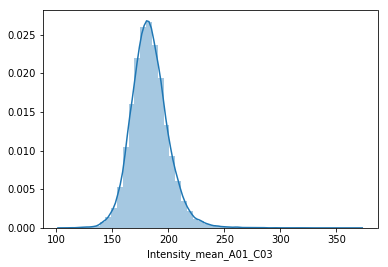

In [54]:
sns.distplot(fv10['Intensity_mean_A01_C03'])

The plot ink color can be specified with the additional parameter `color=`:

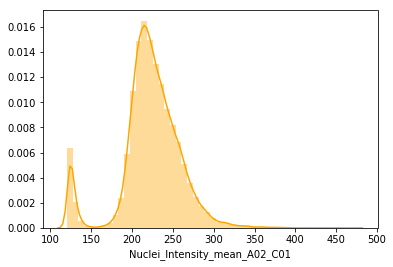

In [55]:
sns.distplot(fv10['Nuclei_Intensity_mean_A02_C01'], color='orange')

-----

## Exercise 9.

Make a distribution plots of the mean Intensity of the *Yap* channel for each of the wells D07, D08, D09, D10. Plot each well in a different color.

Text(0.5,1,'D10')

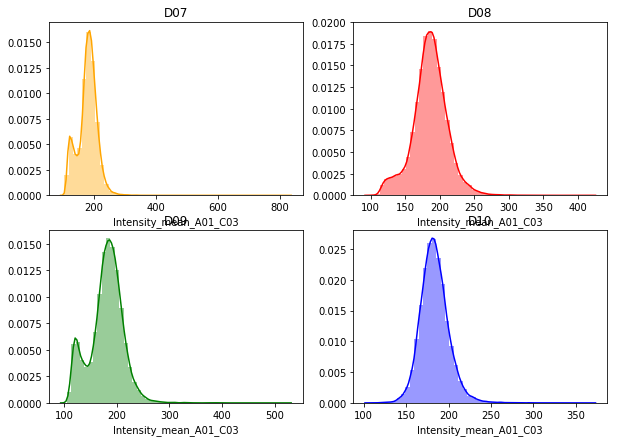

In [56]:
# initialize a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=[10, 7])

# `axes` is the grid of plotting canvaes: axes[row][col]
ul = axes[0][0]  # upper left
ur = axes[0][1]  # upper right
ll = axes[1][0]  # lower left
lr = axes[1][1]  # lower right

# the `sns.*plot()` functions require the drawing canvas as additional parameter `ax=`
sns.distplot(fv07['Intensity_mean_A01_C03'], color='orange', ax=ul); ul.set_title("D07")
sns.distplot(fv08['Intensity_mean_A01_C03'], color='red', ax=ur); ur.set_title("D08")
sns.distplot(fv09['Intensity_mean_A01_C03'], color='green', ax=ll); ll.set_title("D09")
sns.distplot(fv10['Intensity_mean_A01_C03'], color='blue', ax=lr); lr.set_title("D10")

-----

## Box plots

Box plots are provided by [Seaborn function violinplot()](https://seaborn.pydata.org/generated/seaborn.boxplot.html#seaborn.violinplot).  The syntax of the `violinplot()` function we are going to use is the following:
```
boxplot(data=..., x=..., y=..., hue=...)
```
where the named arguments have the following meaning:
- `data` is a table (PanDas `DataFrame`)
- `x` is the *name of a column* of `data` where to draw the x-axis values from; this should be a categorical variable.
- `y` is again the *name of a column* whose distribution detemines the parameters of the box and handles; `y` should name a continuous variable.

The following are optional:
- `hue` is again the *name of a column* of `data` (carrying a categorical variable): if supplied, for each value of `x`, a box+handles of a different color ("hue") will be drawn for each value of `hue`. In other words, by supplying `hue` you can make boxplots of 3D-data `(x,y,hue)`.
- `ax` used for placing a plot on a specific "subplot"

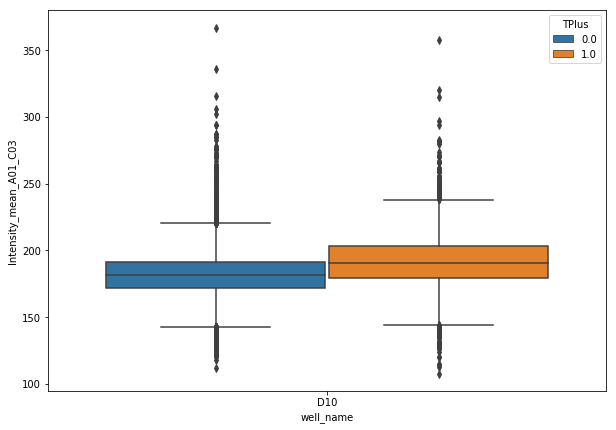

In [57]:
# Initialize the matplotlib figure
fig, ax = plt.subplots(1, figsize=(10, 7))

sns.boxplot(data=merged10, x='well_name', hue='TPlus', y='Intensity_mean_A01_C03', ax=ax)

-----

## Exercise 10.

Make a 2x2 grid of plots, showing box plots of the mean Intensity of the *Yap* channel for each of the wells D07, D08, D09, D10.

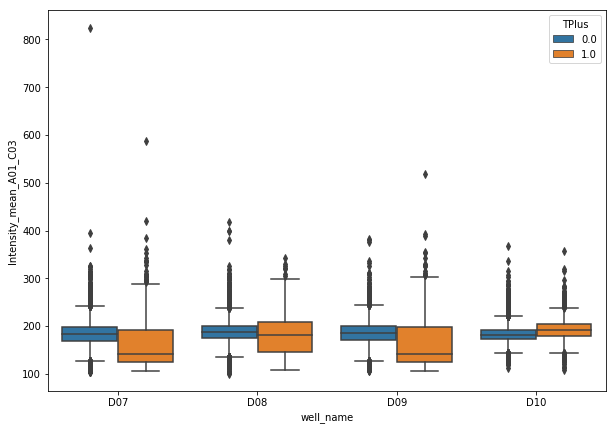

In [58]:
# Initialize the matplotlib figure
fig, ax = plt.subplots(1, figsize=(10, 7))

# the `sns.*plot()` functions require the drawing canvas as additional parameter `ax=`
sns.boxplot(data=good, x='well_name', y='Intensity_mean_A01_C03', hue='TPlus', ax=ax)

-----

## Violin plots

Violin plots are provided by [Seaborn function violinplot()](https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot).  Producing a (useful) violin plot requires specifying quite some parameters; the syntax of the `violinplot()` function we are going to use is the following:
```
violinplot(data=..., x=..., y=..., hue=..., split=..., inner=...)
```
where the named arguments have the following meaning:
- `data` is a table (PanDas `DataFrame`)
- `x` is the *name of a column* of `data` where to draw the x-axis values from; this should be a categorical variable.
- `y` is again the *name of a column* whose distribution will be plotted to make the countour of the "violins"; `y` should name a continuous variable.

The following are optional:
- `hue` is again the *name of a column* of `data` (carrying a categorical variable): if supplied, for each value of `x`, a violin of a different color ("hue") will be drawn for each value of `hue`. In other words, by supplying `hue` you can make violin plots of 3D-data `(x,y,hue)`.
- `split`: if `True` and `hue` is the name of a discrete variable with 2 values, then, for each `x`, each half of the violin plots the `y` values corresponding to the different `hue`.
- `inner`: can be one of:
  * `'quartiles'`: mark the quartiles of the distribution
  * `'box'` make a miniature box plot inside the violin
  * `'point'` mark each data point
  * `None`: no inner decoration of the "violins"

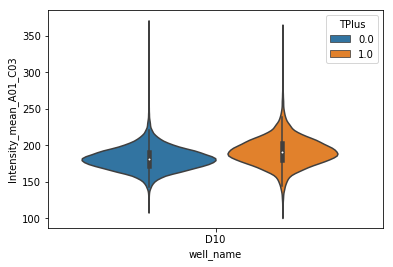

In [59]:
sns.violinplot(data=merged10, x='well_name', y='Intensity_mean_A01_C03', hue='TPlus')

-----

## Exercise 11.

Make a violin plot comparing the distribution of *mean Intensity* for channel *A01_C03* side-by-side for cells with TPlus=0 and TPlus=1.

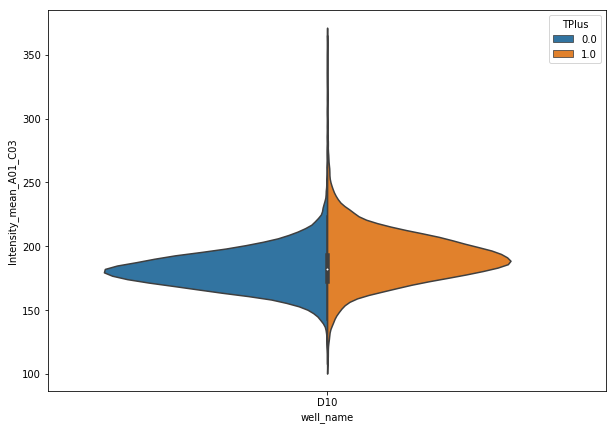

In [60]:
# Initialize the matplotlib figure
fig, ax = plt.subplots(1, figsize=(10, 7))

sns.violinplot(data=merged10, x='well_name', y='Intensity_mean_A01_C03', hue='TPlus', split=True, ax=ax)

## Exercise 12.

Make a 2x2 grid of the above violin plots, allowing to compare across wells.

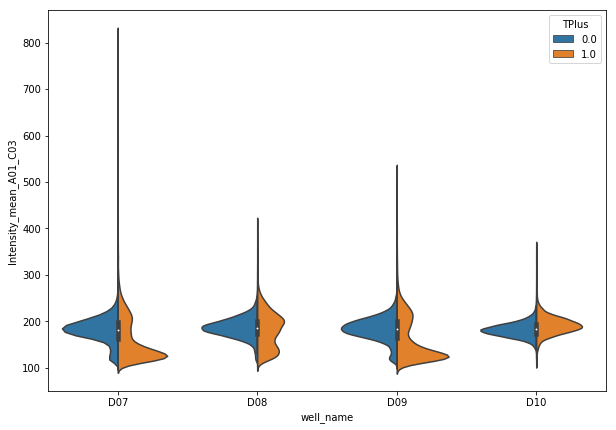

In [61]:
# Initialize the matplotlib figure
fig, ax = plt.subplots(1, figsize=(10, 7))

sns.violinplot(data=good, x='well_name', y='Intensity_mean_A01_C03', hue='TPlus', split=True, ax=ax)

-----